# Address Matching Deep Dive

This notebook experiments with different ways of comparing addresses in order to demonstrate the power of parsed address comparison.

In [149]:
import json
import logging
import os
import random
import re
import sys
import time
import warnings
from numbers import Number
from typing import Callable, Dict, List, Literal, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pytest
import random
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from datasets import Dataset
from fuzzywuzzy import fuzz

from postal.parser import parse_address
from scipy.spatial import distance
from sklearn.metrics import (
    accuracy_score,
    precision_recall_curve,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.model_selection import train_test_split
from sentence_transformers import InputExample, SentenceTransformer, SentencesDataset, SentenceTransformerTrainer, losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction, BinaryClassificationEvaluator
from sentence_transformers.model_card import SentenceTransformerModelCardData
from sentence_transformers.training_args import BatchSamplers, SentenceTransformerTrainingArguments
from tenacity import retry
from torch.utils.data import DataLoader
from torch.optim import RAdam
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer, AutoModel, EarlyStoppingCallback, TrainingArguments, Trainer
from transformers.integrations import WandbCallback

from utils import (
    augment_gold_labels,
    compute_sbert_metrics,
    compute_classifier_metrics,
    format_dataset,
    gold_label_report,
    preprocess_logits_for_metrics,
    structured_encode_address,
    tokenize_function,
    to_dict,
    save_custom_model,
    load_custom_model,
)

#### Pin Random Seeds for Reproducibility

In [150]:
RANDOM_SEED = 31337

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

#### Setup Basic Logging

In [151]:
logging.basicConfig(stream=sys.stderr, level=logging.ERROR)

logger = logging.getLogger(__name__)

#### Ignore Warnings

In [152]:
warnings.simplefilter('ignore', FutureWarning)

#### Configure Weights & Biases

`wandb` needs some environment variables to work.

In [153]:
os.environ["WANDB_LOG_MODEL"] = "end"
os.environ["WANDB_WATCH"] = "gradients"
os.environ["WANDB_PROJECT"] = "libpostal-reborn"
os.environ["WANDB_DISABLED"] = "false"
os.environ["WANDB_IGNORE_GLOBS"] = ".env"

#### Optionally Disable `wandb` Uploads

Weights and Biases can be slow...

In [154]:
os.environ["WANDB_MODE"] = "offline"

#### Configure Huggingface APIs

In [155]:
os.environ["HF_ENDPOINT"] = "https://huggingface.co/"

#### Configure Huggingface APIs

Squash any warnings...

In [156]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#### Configure Pandas to Show More Rows

In [157]:
pd.set_option("display.max_rows", 40)
pd.set_option("display.max_columns", None)

### Use CUDA or MPS if Avaialable

CPU training and even inference with sentence transformers and deep learning models is quite slow. Since all machine learning in this library is based on [PyTorch](https://pytorch.org/get-started/locally/), we can assign all ML operations to a GPU in this one block of code. Otherwise we default to CPU without acceleration. The notebook is still workable in this mode, you just may need to grab a cup of tea or coffee while you wait for it to train the Sentence-BERT model below.

In [158]:
# Check for CUDA or MPS availability and set the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    logger.debug("Using Apple GPU acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    logger.debug("Using NVIDIA CUDA GPU acceleration")
else:
    device = "cpu"
    logger.debug("Using CPU for ML")

device

device(type='mps')

### Use Weights & Biases for Logging Metrics

Weights & Biases has a free account for individuals with public projects. Using it will produce charts during our training runs that anyone can view. You can create your own project for this notebook and login with that key to log your own training runs.

You may need to run the following command from your shell before the next cell, otherwise you will have to paste your project key into the 

```bash
wandb login
```

In [159]:
# Login to wandb. Comment out if you already haven't via `wandb login` from a CLI
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

## Implementing a Structured Address Matcher

Let's start our exercise by using the structured address data provided by [Libpostal](https://github.com/openvenues/libpostal) to parse them for matching. We write a function for each address part to deal with missing fields without duplicating a lot of logic.

We start with something quite literal and basic. We'll improve it as we go.

In [12]:
def parse_match_address(address1: str, address2: str) -> Literal[0, 1]:
    """parse_match_address implements address matching using the precise, parsed structure of addresses."""
    address1 = to_dict(parse_address(address1))
    address2 = to_dict(parse_address(address2))

    def match_road(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_road - literal road matching, negative if either lacks a road"""
        if ("road" in address1) and ("road" in address2):
            if address1["road"] == address2["road"]:
                logger.debug("road match")
                return 1
            else:
                logger.debug("road mismatch")
                return 0
        logger.debug("road mismatch")
        return 0

    def match_house_number(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_house_number - literal house number matching, negative if either lacks a house_number"""
        if ("house_number" in address1) and ("house_number" in address2):
            if address1["house_number"] == address2["house_number"]:
                logger.debug("house_number match")
                return 1
            else:
                logger.debug("house_number mismatch")
                return 0
        logger.debug("house_number mistmatch")
        return 0

    def match_unit(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_unit - note a missing unit in both is a match"""
        if "unit" in address1:
            if "unit" in address2:
                logger.debug("unit match")
                return 1 if (address1["unit"] == address2["unit"]) else 0
            else:
                logger.debug("unit mismatch")
                return 0
        if "unit" in address2:
            if "unit" in address1:
                logger.debug("unit match")
                return 1 if (address1["unit"] == address2["unit"]) else 0
            else:
                logger.debug("unit mismatch")
                return 0
        # Neither address has a unit, which is a default match
        return 1

    def match_postcode(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_postcode - literal matching, negative if either lacks a postal code"""
        if ("postcode" in address1) and ("postcode" in address2):
            if address1["postcode"] == address2["postcode"]:
                logger.debug("postcode match")
                return 1
            else:
                logger.debug("postcode mismatch")
                return 0
        logger.debug("postcode mismatch")
        return 0

    def match_country(address1: Dict, address2: Dict) -> Literal[0, 1]:
        """match_country - literal country matching - pass if both don't have one"""
        if ("country" in address1) and ("country" in address2):
            if address1["country"] == address2["country"]:
                logger.debug("country match")
                return 1
            else:
                logger.debug("country mismatch")
                return 0
        # One or none countries should match
        logger.debug("country match")
        return 1

    # Combine the above to get a complete address matcher
    if (
        match_road(address1, address2)
        and match_house_number(address1, address2)
        and match_unit(address1, address2)
        and match_postcode(address1, address2)
        and match_country(address1, address2)
    ):
        logger.debug("overall match")
        return 1
    else:
        logger.debug("overall mismatch")
        return 0

In [13]:
# Yup down to house_number ...
parse_match_address(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way Lawrenceville, GA, 30044",
)

1

In [14]:
fuzz.ratio(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way Lawrenceville, GA, 30044",
)

97

In [15]:
# Yup down to unit ...
parse_match_address(
    "120 Ralph McGill Blvd, Apt 101, Atlanta, GA 30308, USA",
    "120 Ralph McGill Blvd, Apt 101, Atlanta GA 30308",
)

1

In [16]:
fuzz.ratio(
    "120 Ralph McGill Blvd, Apt 101, Atlanta, GA 30308, USA",
    "120 Ralph McGill Blvd, Apt 101, Atlanta GA 30308",
)

94

In [17]:
# Nope if only one uses an abbreviation ...
parse_match_address(
    "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
    "120 Ralph McGill Boulevard, Apt 333, Atlanta, GA 30308",
)

0

In [18]:
fuzz.ratio(
    "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
    "120 Ralph McGill Boulevard, Apt 333, Atlanta, GA 30308",
)

95

In [19]:
# Nope if one character in the streetname is off ...
parse_match_address(
    "120 Ralp McGill Blvd, Apt 333, Atlanta, GA 30308",
    "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
)

0

In [20]:
fuzz.ratio(
    "120 Ralp McGill Blvd, Apt 333, Atlanta, GA 30308",
    "120 Ralph McGill Blvd, Apt 333, Atlanta, GA 30308",
)

99

### Literal is Too Precise!

While it is useful to parse addresses and implement literal matching logic as we did above, as the third example indicates, an abbreviation or a single typo results in a mistmatch. We're going to write a more complex, approximate logical matcher below using string distance and text embeddings.

Depending on your application you might relax this criteria to include corner cases such as missing postcodes. Before we get into that, let's create some training and evaluation data using hand-labeled data with an LLM data augmentation strategy to generate a lot of labeled records.

## Data Augmentation with the OpenAI GPT4o API

We need training data for our supervised learning approaches to addres matching. Open the sister notebook [Address Data Augmentation.ipynb](Address%20Matching%20Deep%20Dive.ipynb) before procceeding to further cells in order to create some training data via minimal manual labeling and programmatic data labeling for data augmentation. This will teach you programmatic data labeling, a critical skill that LLMs make MUCH EASIER because they understand things like the semantics of global addresses.

In [21]:
gold_df = pd.read_csv("data/gold.csv")

In [22]:
# If you want to start from here and not run the data augmentation pipeline again...
augment_results_df = pd.read_parquet("data/training.6.parquet")

augment_results_df.head(20)

,Address1,Address2,Description,Label
0,"123 E Main St, Springfield, IL 62701","123 East Main Street, Springfield, Illinois 62701",Different directional prefix formats for same ...,1.0
1,"456 W Elm St, Boston, MA 02118","456 West Elm Street, Boston, Massachusetts 02118",Different directional prefix formats for same ...,1.0
2,"789 S Oak St, Denver, CO 80203","789 South Oak Street, Denver, Colorado 80203",Different directional prefix formats for same ...,1.0
3,"321 N Pine St, Seattle, WA 98101","321 North Pine Street, Seattle, Washington 98101",Different directional prefix formats for same ...,1.0
4,"654 E Maple St, Austin, TX 73301","654 East Maple Street, Austin, Texas 73301",Different directional prefix formats for same ...,1.0
5,"987 W Cedar St, San Francisco, CA 94102","987 West Cedar Street, San Francisco, Californ...",Different directional prefix formats for same ...,1.0
6,"246 S Birch St, New York, NY 10001","246 South Birch Street, New York, New York 10001",Different directional prefix formats for same ...,1.0
7,"135 N Cedar Ave, Chicago, IL 60601","135 North Cedar Avenue, Chicago, Illinois 60601",Different directional prefix formats for same ...,1.0
8,"864 E Pine Ave, Los Angeles, CA 90001","864 East Pine Avenue, Los Angeles, California ...",Different directional prefix formats for same ...,1.0
9,"753 W Spruce St, Houston, TX 77001","753 West Spruce Street, Houston, Texas 77001",Different directional prefix formats for same ...,1.0


### Data Augmentation Complete!

Starting by hand labeling under 100 records and iterating a few times on data augmentation instructions for GPT4o, we have multiplied them by many times to get almost 10,000 synthetic records! This is enough to fine-tune a `SentenceTransformer` or semantic text similarity classifier model. GPT4o is a powerful tool for data augmentation! This can work for a variety of problems.

LLM based data augmentation is a powerful tool for your data labeling toolbox.

# Comparing Different Approaches to Address Matching

Now we're going to compare the following methods of address matching:

1) Database Lookups - we'l use [pycountry](https://pypi.org/project/pycountry/) ([github](https://github.com/pycountry/pycountry)) to improve international address matching (see [PyCountry Nation Matching](PyCountry%20Nation%20Matching.ipynb)).
2) Text Embeddings - we'll use transfer learning to load an existing [SentenceTransformer](https://sbert.net) model to sentence encode pairs of addresses to create fixed-length embeddings for each address and then compute a similarity score via [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). This won't work without fine-tuning, so we fine-tune the model to the task.
3) Deep Matching Model - We'll train a deep semantic textual similarity classification model based on a Siamese BERT network as defined in [Sentence-BERT](https://arxiv.org/abs/1908.10084) to classify address pairs as matching or not matching.

# Machine Learning Approaches to Address Matching

In this section we pursue two machine learning approaches to address matching, in order of sophistication. First we fine-tune a pre-trained embedding model to our task, try it on our data and search for a threshold similarity that results in good performance for our address matching problem. Second we build a Siamese BERT network model based on [Sentence-BERT](https://arxiv.org/abs/1908.10084) to classify pairs of addresses as match or mismatch. We will train it using the same dataset we use to fine-tune a sentence transformer, and if we have enough training data this will likely be a more powerful approach.

## Text Embeddings, Sentence Encoding, `SentenceTransformers`, Vector Distance and Cosine Similarity

Text embeddings are trained on large volumes of text that include addresses. As a result they have some understanding of address strings and can do a form of semantic comparison that is less explicit than logical comparisons with address parsing. They're an important benchmark to explore. Huggingface has an excellent [introduction to sentence similarity](https://huggingface.co/tasks/sentence-similarity).

In our first machine learning approach, we are going to use transfer learning to load a pre-trained [sentence transformer](https://sbert.net) models from huggingface. We will use the training data we've prepared to fine-tune this model to our task, before rigorously evaluating it along with our other approaches.

Sentence transformers sentence encode strings of different distances into fixed-length vectors, a technique called sentence encoding. Once two address strings are embedded into a pair of equal length vectors, they can be compared with cosine similarity to get a distance, the inverse of which is a similarity score.

### Convert our `pd.DataFrame` to a `List[sentence_transformers.InputExample]`

First we need to convert our Pandas `DataFrame` to a list of sentence transformer input examples. `InputExamples` require two fields `texts=List[str, str]` and `label`.

In [23]:
train_df, tmp_df = train_test_split(augment_results_df, test_size=0.2, shuffle=True)
eval_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

train_dataset = Dataset.from_dict({
    "sentence1": train_df["Address1"].tolist(),
    "sentence2": train_df["Address2"].tolist(),
    "label": train_df["Label"].tolist(),
})

eval_dataset = Dataset.from_dict({
    "sentence1": eval_df["Address1"].tolist(),
    "sentence2": eval_df["Address2"].tolist(),
    "label": eval_df["Label"].tolist(),
})

test_dataset = Dataset.from_dict({
    "sentence1": test_df["Address1"].tolist(),
    "sentence2": test_df["Address2"].tolist(),
    "label": test_df["Label"].tolist(),
})

print(f"Training data:   {len(train_df):,}")
print(f"Validation data: {len(eval_df):,}")
print(f"Test data        {len(eval_df):,}")

Training data:   8,024
Validation data: 1,003
Test data        1,003


### Configure Fine-Tuning, Initialize a `SentenceTransformer`

To use the training data we prepared to fine-tune a `SentenceTransformer`, we need to select and load a pre-trained model from Huggingface Hub. Here are some models you can try:

* [sentence-transformers/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) - multilingual paraphrase models are designed to compare sentences in terms of their semantics.
* [BAAI/bge-m3](https://huggingface.co/BAAI/bge-m3) - a robust, multilingual model optimized for a variety of tasks
* [sentence-transformers/paraphrase-multilingual-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2) - MPNet is another paraphrase model architecture we can fine-tune for address comparison
* [sentence-transformers/all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) - a top performing MPNet model

In [24]:
SBERT_MODEL = "paraphrase-multilingual-MiniLM-L12-v2"
VARIANT = "original"
MODEL_SAVE_NAME = (SBERT_MODEL + "-" + VARIANT).replace("/", "-")

# Make sure these match the values in the data augmentation notebook for accurate loggging and reporting
CLONES_PER_RUN = 100
RUNS_PER_EXAMPLE = 2

EPOCHS = 6
BATCH_SIZE = 32
PATIENCE = 2
LEARNING_RATE = .00005
DATASET_MULTIPLE = CLONES_PER_RUN * RUNS_PER_EXAMPLE
SBERT_OUTPUT_FOLDER = f"data/fine-tuned-sbert-{MODEL_SAVE_NAME}"
SAVE_EVAL_STEPS = 100

### Initialize Weights & Biases

Weights and biases `wandb` package makes it simple to monitor the performance of your training runs.

In [25]:
# Initialize Weights & Biases
wandb.init(
    entity="rjurney",
    # set the wandb project where this run will be logged
    project="libpostal-reborn",
    # track hyperparameters and run metadata
    config={
        "variant": VARIANT,
        "dataset_multiple": DATASET_MULTIPLE,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "patience": PATIENCE,
        "learning_rate": LEARNING_RATE,
        "sbert_model": SBERT_MODEL,
        "model_save_name": MODEL_SAVE_NAME,
        "sbert_output_folder": SBERT_OUTPUT_FOLDER,
        "save_eval_steps": SAVE_EVAL_STEPS,
    },
    save_code=True,
)

### Setup our `SentenceTransformer` Model

Choose the model to fine-tune above in `SBERT_MODEL` and instantiate it below.

In [26]:
sbert_model = SentenceTransformer(
    SBERT_MODEL,
    device=device,
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name=f"{SBERT_MODEL}-address-matcher-{VARIANT}",
    ),
)

### Evaluate our Model Before Fine-Tuning

Let's see what it can do without fine-tuning, then we'll compare our subjective results afterwards. This won't work very well, fine-tuning is required!

In [27]:
def sbert_compare(address1: str, address2: str) -> float:
    """sbert_compare - sentence encode each address into a fixed-length text embedding.
    Fixed-length means they can be compared with cosine similarity."""
    embedding1 = sbert_model.encode(address1)
    embedding2 = sbert_model.encode(address2)

    # Compute cosine similarity
    return 1 - distance.cosine(embedding1, embedding2)


def sbert_match(row: pd.Series) -> pd.Series:
    """sbert_match - SentenceTransformer address matching, float iytoyt"""
    return sbert_compare(row["Address1"], row["Address2"])


def sbert_compare_binary(address1: str, address2: str, threshold: float = 0.5) -> Literal[0, 1]:
    """sbert_match - compare and return a binary match"""
    similarity = sbert_compare(address1, address2)
    return 1 if similarity >= threshold else 0


def sbert_match_binary(row: pd.Series, threshold: float = 0.5) -> pd.Series:
    """sbert_match_binary - SentenceTransformer address matching, binary output"""
    return sbert_compare_binary(row["Address1"], row["Address2"], threshold=threshold)

In [28]:
# Still too similar - very hard to train them away from this behavior!
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "102 Oak Lane, Atlanta, GA 30308",
)

0.9887310599046897

In [29]:
# A little bit further away ...
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "101 Oak Ln., Atlanta, GA 30308",
)

0.9080112054372381

In [30]:
# Properly distant ...
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "1202 Oak Rd., Lawrenceville, GA 30304",
)

0.7771668960380212

In [31]:
# Properly similar ...
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way, Lawrenceville, GA 30044, USA",
)

0.9754176576820044

### Evaluate the Test Set with the Untrained Model

Let's see how well the [paraphrase-multilingual-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2) model does on its own. This is our baseline score.

In [32]:
# Initialize the evaluator
binary_acc_evaluator = BinaryClassificationEvaluator(
    sentences1=eval_dataset["sentence1"],
    sentences2=eval_dataset["sentence2"],
    labels=eval_dataset["label"],
    name=SBERT_MODEL,
)
pd.DataFrame([binary_acc_evaluator(sbert_model)])

,paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold,paraphrase-multilingual-MiniLM-L12-v2_dot_f1,paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold,paraphrase-multilingual-MiniLM-L12-v2_dot_precision,paraphrase-multilingual-MiniLM-L12-v2_dot_recall,paraphrase-multilingual-MiniLM-L12-v2_dot_ap,paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy,paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy_threshold,paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1,paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1_threshold,paraphrase-multilingual-MiniLM-L12-v2_manhattan_precision,paraphrase-multilingual-MiniLM-L12-v2_manhattan_recall,paraphrase-multilingual-MiniLM-L12-v2_manhattan_ap,paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy,paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy_threshold,paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1,paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1_threshold,paraphrase-multilingual-MiniLM-L12-v2_euclidean_precision,paraphrase-multilingual-MiniLM-L12-v2_euclidean_recall,paraphrase-multilingual-MiniLM-L12-v2_euclidean_ap,paraphrase-multilingual-MiniLM-L12-v2_max_accuracy,paraphrase-multilingual-MiniLM-L12-v2_max_accuracy_threshold,paraphrase-multilingual-MiniLM-L12-v2_max_f1,paraphrase-multilingual-MiniLM-L12-v2_max_f1_threshold,paraphrase-multilingual-MiniLM-L12-v2_max_precision,paraphrase-multilingual-MiniLM-L12-v2_max_recall,paraphrase-multilingual-MiniLM-L12-v2_max_ap
0,0.602193,0.714667,0.726787,0.578766,0.572029,0.996337,0.50633,0.591226,13.357239,0.72372,13.357239,0.572495,0.983516,0.679777,0.60319,60.44915,0.72962,60.44915,0.579914,0.983516,0.498341,0.604187,3.521773,0.728756,3.813365,0.579459,0.981685,0.498954,0.604187,60.44915,0.72962,60.44915,0.579914,0.996337,0.679777


### Computing Metrics with `sklearn.metrics`

We use [scikit-learn metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) instead to compute our evaluation metrics.

In [33]:
# This will rapidly train the embedding model. MultipleNegativesRankingLoss did not work.
loss = losses.ContrastiveLoss(model=sbert_model)

sbert_args = SentenceTransformerTrainingArguments(
    output_dir=SBERT_OUTPUT_FOLDER,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_ratio=0.1,
    run_name=SBERT_MODEL,
    load_best_model_at_end=True,
    save_total_limit=5,
    save_steps=SAVE_EVAL_STEPS,
    eval_steps=SAVE_EVAL_STEPS,
    save_strategy="steps",
    eval_strategy="steps",
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    learning_rate=LEARNING_RATE,
    logging_dir="./logs",
)

trainer = SentenceTransformerTrainer(
    model=sbert_model,
    args=sbert_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=binary_acc_evaluator,
    compute_metrics=compute_sbert_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

trainer.evaluate()
trainer.train()

Step,Training Loss,Validation Loss,Paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy,Paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Cosine F1,Paraphrase-multilingual-minilm-l12-v2 Cosine F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Cosine Precision,Paraphrase-multilingual-minilm-l12-v2 Cosine Recall,Paraphrase-multilingual-minilm-l12-v2 Cosine Ap,Paraphrase-multilingual-minilm-l12-v2 Dot Accuracy,Paraphrase-multilingual-minilm-l12-v2 Dot Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Dot F1,Paraphrase-multilingual-minilm-l12-v2 Dot F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Dot Precision,Paraphrase-multilingual-minilm-l12-v2 Dot Recall,Paraphrase-multilingual-minilm-l12-v2 Dot Ap,Paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy,Paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Manhattan F1,Paraphrase-multilingual-minilm-l12-v2 Manhattan F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Manhattan Precision,Paraphrase-multilingual-minilm-l12-v2 Manhattan Recall,Paraphrase-multilingual-minilm-l12-v2 Manhattan Ap,Paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy,Paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Euclidean F1,Paraphrase-multilingual-minilm-l12-v2 Euclidean F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Euclidean Precision,Paraphrase-multilingual-minilm-l12-v2 Euclidean Recall,Paraphrase-multilingual-minilm-l12-v2 Euclidean Ap,Paraphrase-multilingual-minilm-l12-v2 Max Accuracy,Paraphrase-multilingual-minilm-l12-v2 Max Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Max F1,Paraphrase-multilingual-minilm-l12-v2 Max F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Max Precision,Paraphrase-multilingual-minilm-l12-v2 Max Recall,Paraphrase-multilingual-minilm-l12-v2 Max Ap
100,No log,0.024751,0.761715,0.849213,0.805533,0.849213,0.724744,0.906593,0.832721,0.738784,12.224442,0.791209,9.154406,0.692308,0.923077,0.836286,0.726820,31.723263,0.775316,34.718288,0.682451,0.897436,0.793861,0.724826,1.918679,0.776471,2.324001,0.679012,0.906593,0.793778,0.761715,31.723263,0.805533,34.718288,0.724744,0.923077,0.836286
200,No log,0.010474,0.922233,0.881492,0.928177,0.881492,0.933333,0.923077,0.974433,0.856431,11.000132,0.874241,10.560261,0.830313,0.923077,0.920055,0.877368,31.488804,0.887876,31.488804,0.883848,0.891941,0.953952,0.877368,2.068511,0.888688,2.068511,0.878354,0.899267,0.954324,0.922233,31.488804,0.928177,31.488804,0.933333,0.923077,0.974433
300,No log,0.007161,0.957129,0.871420,0.960802,0.871420,0.956443,0.965201,0.989657,0.891326,12.223917,0.903283,12.145710,0.876076,0.932234,0.955422,0.921236,29.810850,0.926027,33.899479,0.923497,0.928571,0.979147,0.922233,2.133923,0.928440,2.133923,0.930147,0.926740,0.979502,0.957129,29.810850,0.960802,33.899479,0.956443,0.965201,0.989657
400,No log,0.004446,0.968096,0.861937,0.970856,0.829362,0.965580,0.976190,0.994476,0.919242,13.603943,0.926027,13.603943,0.923497,0.928571,0.967802,0.947159,40.474823,0.952295,41.216068,0.936283,0.968864,0.988649,0.948156,2.548373,0.952899,2.548373,0.942652,0.963370,0.988652,0.968096,40.474823,0.970856,41.216068,0.965580,0.976190,0.994476
500,0.012500,0.002957,0.989033,0.876668,0.989880,0.876668,0.994455,0.985348,0.997698,0.930209,13.543964,0.937050,12.951462,0.920495,0.954212,0.975515,0.972084,42.792831,0.974729,42.792831,0.960854,0.989011,0.994477,0.971087,2.665913,0.973803,2.684689,0.960784,0.987179,0.994476,0.989033,42.792831,0.989880,42.792831,0.994455,0.989011,0.997698
600,0.012500,0.002523,0.990030,0.870730,0.990826,0.870730,0.992647,0.989011,0.998202,0.934197,14.299244,0.940000,14.299244,0.933213,0.946886,0.978498,0.977069,39.426003,0.979034,40.343513,0.974592,0.983516,0.995781,0.978066,2.611123,0.979964,2.611123,0.974638,0.985348,0.995820,0.990030,39.426003,0.990826,40.343513,0.992647,0.989011,0.998202
700,0.012500,0.001912

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

TrainOutput(global_step=1506, training_loss=0.004920770943067117, metrics={'train_runtime': 255.1951, 'train_samples_per_second': 188.656, 'train_steps_per_second': 5.901, 'total_flos': 0.0, 'train_loss': 0.004920770943067117, 'epoch': 6.0})

In [34]:
print(f"Best model checkpoint path: {trainer.state.best_model_checkpoint}")

Best model checkpoint path: data/fine-tuned-sbert-paraphrase-multilingual-MiniLM-L12-v2-original/checkpoint-1500


In [35]:
pd.DataFrame([trainer.evaluate()])

,eval_loss,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_f1,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_precision,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_recall,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_ap,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_precision,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_recall,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_ap,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_precision,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_recall,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_ap,eval_paraphrase-multilingual-MiniLM-L12-v2_max_accuracy,eval_paraphrase-multilingual-MiniLM-L12-v2_max_accuracy_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_max_f1,eval_paraphrase-multilingual-MiniLM-L12-v2_max_f1_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_max_precision,eval_paraphrase-multilingual-MiniLM-L12-v2_max_recall,eval_paraphrase-multilingual-MiniLM-L12-v2_max_ap,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.00116,0.993021,0.903927,0.993596,0.836542,0.992687,0.994505,0.999571,0.967099,14.538573,0.970243,14.538573,0.955595,0.985348,0.987792,0.989033,36.789665,0.989973,40.24852,0.985481,0.994505,0.998492,0.99003,2.44664,0.990842,2.44664,0.990842,0.990842,0.998611,0.993021,36.789665,0.993596,40.24852,0.992687,0.994505,0.999571,1.5073,665.414,21.23,6.0


In [36]:
trainer.save_model(SBERT_OUTPUT_FOLDER)

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

In [37]:
wandb.finish()

eval/loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,▁▄▇▇█████████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,▁▆▇▇▆▇▇▇▅▇▅▇█████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,▁▆███████████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,▁▃▆▇▇████████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,▁▇▇▇▆▇▇▇▆▆▆▇█▆▇▆▆
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,▁▄▇▇▇████████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,█▁▂▆▆▇▇██████████
eval/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,▁▄▆▇▇▇▇██████████
eval/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold,▅▃▁▃▆▆▇▆▇▅▇▇▆████
eval/paraphrase-multilingual-MiniLM-L12-v2_dot_ap,▁▅▆▇█████████████


### Try the Model from Our Best Epoch

We fine-tuned the model for `EPOCHS` nubmer of epochs, but the last epoch isn't always best. The `TrainingArgument` `load_best_model_at_end=True` loads the model at the end.

Another way to load the best model is to load our output folder and evaluate that `SentenceTransformer` on some examples to get a gestalt sense for its performance.

```python
sbert_model = SentenceTransformer(OUTPUT_FOLDER, device=device)
```

In [38]:
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "102 Oak Lane, Atlanta, GA 30308",
)

0.15073898993503043

In [39]:
sbert_compare(
    "101 Oak Lane, Macon, GA 30308",
    "101 Oak Lane, Atlanta, GA 30408",
)

0.9498591837149909

In [40]:
sbert_compare(
    "101 Oak Lane, Atlanta, GA 30308",
    "101 Oak Ln., Atlanta, GA 30308",
)

0.9807205164923688

In [41]:

sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "1202 Oak Rd., Lawrenceville, GA 30304",
)

0.4511403898242934

In [42]:
sbert_compare(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way, Lawrenceville, GA 30044, USA",
)

0.9233244667710073

### Evaluate ROC Curve to Determine Optimum Similarity Threshold

0.5 is an arbitrary line on which to divide positive (match, 1) and negative (mismatch, 0). Let's evaluate the ROC Curve of the F1 score to see what it should be set to. Recall that the `sbert_match` function has a `threshold: float = 0.5` argument.

#### Evaluate on our Augmented Test Dataset

First we'll evaluate the ROC curve on our augmented test dataset.

In [43]:
y_true = test_df["Label"]
y_scores = test_df.apply(sbert_match, axis=1)

In [44]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.9088101614582614
Best F1 Score: 0.9922779922779923
AUC-ROC: 0.9992596425586117


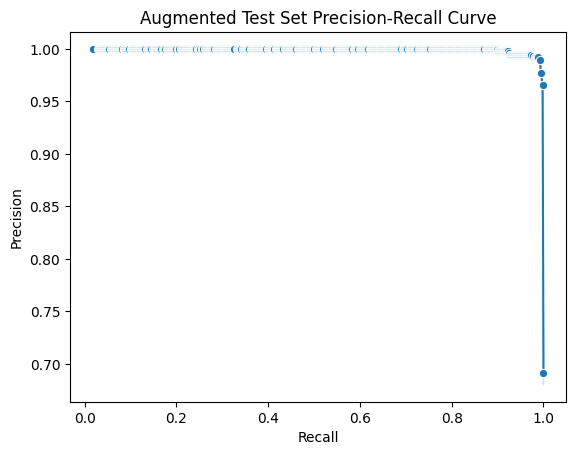

In [45]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Augmented Test Set Precision-Recall Curve')
plt.show()

### Plot a ROC Curve for our Gold Labeled Data

We need to see the ROC Curve for our gold labeled data as well. We care more about performance on this data.

In [46]:
y_true = gold_df["Label"]
y_scores = gold_df.apply(sbert_match, axis=1)

In [47]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.8120125026504897
Best F1 Score: 0.8
AUC-ROC: 0.7658536585365855


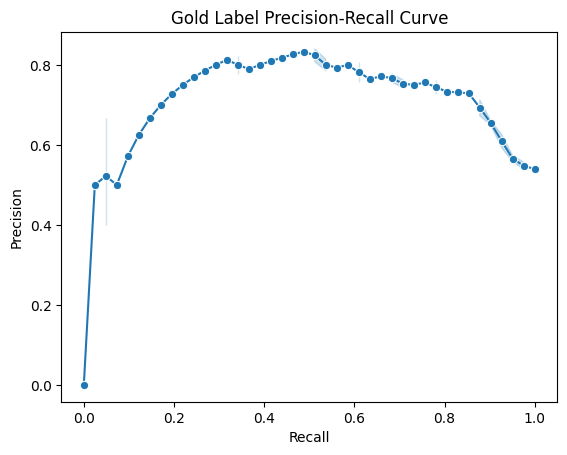

In [48]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gold Label Precision-Recall Curve')
plt.show()

### Debugging Errors on our Gold Labels

Let's evaluate the data using our `gold_label_report` function with the best F1 score. Then we can view the errors and figure out where our model is failing.

In [49]:
raw_df, grouped_df = gold_label_report(
    gold_df,
    [
        # strict_parse_match,
        # parse_match_country,
        sbert_match_binary,
    ],
    threshold=best_threshold
)

#### Label Description Group Analysis

You can see the types of address pairs we are failing on. This can guide our data augmentation / programmatic labeling work at a high level.

In [50]:
grouped_df.head(40)

,sbert_match_binary_acc
Description,
Abbreviated street type for same address should match,1.0
Abbreviated vs. full street names for same address should match,1.0
Addition of parenthetical details for same address should match,1.0
Adjacent or nearby building numbers means different address,0.0
Close numerical variants are different addresses,1.0
Common misspellings for same address should match,1.0
Common typographical errors in same address should match,1.0
Completely different addresses that don't match,0.0
Different addresses in the same country that don't match,0.5


In [51]:
grouped_df["sbert_match_binary_acc"].sort_values().head(40)

Description
Incomplete address vs full address may match                                             0.0
Different postal codes means different address                                           0.0
Different languages for same address should match                                        0.0
Different unit numbers means different address                                           0.0
Different units in a building means different address                                    0.0
Different countries means different address                                              0.0
Formal and localized format of same address should match                                 0.0
Different states means different address                                                 0.0
Missing unit number in match means different address                                     0.0
Completely different addresses that don't match                                          0.0
Similar but different street numbers                      

#### What it Got Right ...

In [52]:
# Truthiness analysis
correct_df = raw_df[raw_df["sbert_match_binary_correct"]].reset_index()
print(f"Number correct: {len(correct_df):,}")

correct_df.head(20)

Number correct: 58


,index,Description,Address1,Address2,Label,sbert_match_binary,sbert_match_binary_correct
0,0,Different directional prefix formats for same ...,"2024 NW 5th Ave, Miami, FL 33127","2024 Northwest 5th Avenue, Miami, Florida 33127",1,1,True
1,1,Abbreviated street type for same address shoul...,"10200 NE 12th St, Bellevue, WA 98003","10200 NE 12th Street, Bellevue, WA 98003",1,1,True
2,2,Common misspellings for same address should match,"1600 Pennsylvna Ave NW, Washington, DC 20500","1600 Pennsylvania Avenue NW, Washington, DC 20500",1,1,True
3,3,Different directional prefix formats for same ...,"550 S Hill St, Los Angeles, CA","550 South Hill Street, Los Angeles, California",1,1,True
4,5,Numerical variations for same address should m...,"Third Ave, New York, NY","3rd Avenue, New York, New York",1,1,True
5,6,Variant format of same address should match,"350 Fifth Avenue, New York, NY 10118","Empire State Bldg, 350 5th Ave, NY, NY 10118",1,1,True
6,7,Variant format of same address should match,"Çırağan Caddesi No: 32, 34349 Beşiktaş, Istanb...","Ciragan Palace Hotel, Ciragan Street 32, Besik...",1,1,True
7,10,Variant formats of same address should match,Shànghǎi Shì Huángpǔ Qū Nánjīng Dōng Lù 318 Hào,Shànghǎi Huángpǔ Nánjīng Dōng Lù 318 Hào,1,1,True
8,12,Different character sets for same address shou...,"16, MG Road, Bangalore, Karnataka 560001, India","16, एमजी रोड, बैंगलोर, कर्नाटक 560001",1,1,True
9,13,Missing state but has postal code and country ...,"Pariser Platz 2, 10117 Berlin, Germany","Pariser Platz 2, 10117 Berlin, Berlin, Germany",1,1,True


In [53]:
# Error analysis
wrong_df = raw_df[raw_df["sbert_match_binary_correct"] == False].reset_index()
print(f"Number wrong: {len(wrong_df):,}")

wrong_df.head(20)

Number wrong: 18


,index,Description,Address1,Address2,Label,sbert_match_binary,sbert_match_binary_correct
0,4,Incomplete address vs full address may match,"1020 SW 2nd Ave, Portland","1020 SW 2nd Ave, Portland, OR 97204",1,0,False
1,8,Different character sets for same address shou...,北京市朝阳区建国路88号,Běijīng Shì Cháoyáng Qū Jiànguó Lù 88 Hào,1,0,False
2,9,Variant formats of same address should match,上海市黄浦区南京东路318号,上海黄浦南京东路318号,1,0,False
3,11,Formal and localized format of same address sh...,"B-14, Connaught Place, New Delhi, Delhi 110001...","B-14, CP, ND, DL 110001",1,0,False
4,16,Different languages for same address should match,北京市东城区东长安街16号,"16 Dongchang'an St, Dongcheng, Beijing, China",1,0,False
5,41,Different street numbers means different address,"101 Oak Lane, Marietta, GA 30008","102 Oak Lane, Marietta, GA 30008",0,1,False
6,42,Different street names means different address,"101 Market Square, Seattle, WA 98039","101 Davis Place, Seattle, WA 98039",0,1,False
7,44,Different cities means different address,"2754 Ralph McGill Blvd, Atlanta, GA","2754 Ralph McGill Blvd, Macon, GA",0,1,False
8,51,Close numerical variants are different addresses,"75 West 50th Street, New York, NY 10112","50 West 75th Street, New York, NY 10023",0,1,False
9,52,Similar road names can be different addresses,北京市朝阳区朝阳门外大街6号,北京市朝阳区朝阳门内大街6号,0,1,False


## Structured Address Matching with Libpostal, PyTorch and `Sentence-BERT`

Our next strategy will be to parse the addresses using Libpostal and then to encode them in a way that perserves the parsed staructure. Libposstal lowercases the address parts it produces, so we need to train a lowercase `SentenceTransformer` model. We will then load the weights of this pre-trained model as the embedding layers of a deep network architecture called `SentenceBERT` to build a classifier for pairs of addresses that can achieve better performance than fine-tuned sentence transformers and cosine similarity alone.

### Fine-Tuning a Lowercase `SentenceTransformer`

My first pass at this method did not work whatsoever - the performance of the matcher was abysmal. This was because Libpostal *lowercases* addresses when it parses them, and I did NOT do that to the training data on a first pass :) Once I did that and retrained below - things worked much better!

#### Lowercase our Dataset

In [54]:
lower_augment_results_df = augment_results_df.copy(deep=True)

lower_augment_results_df["Address1"] = lower_augment_results_df["Address1"].str.lower()
lower_augment_results_df["Address2"] = lower_augment_results_df["Address2"].str.lower()

In [55]:
train_df, tmp_df = train_test_split(lower_augment_results_df, test_size=0.2, shuffle=True)
eval_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

train_dataset = Dataset.from_dict({
    "sentence1": train_df["Address1"].tolist(),
    "sentence2": train_df["Address2"].tolist(),
    "label": train_df["Label"].tolist(),
})

eval_dataset = Dataset.from_dict({
    "sentence1": eval_df["Address1"].tolist(),
    "sentence2": eval_df["Address2"].tolist(),
    "label": eval_df["Label"].tolist(),
})

test_dataset = Dataset.from_dict({
    "sentence1": test_df["Address1"].tolist(),
    "sentence2": test_df["Address2"].tolist(),
    "label": test_df["Label"].tolist(),
})

print(f"Training data:   {len(train_df):,}")
print(f"Validation data: {len(eval_df):,}")
print(f"Test data        {len(eval_df):,}")

Training data:   8,024
Validation data: 1,003
Test data        1,003


In [110]:
SBERT_MODEL_LOWER = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
VARIANT = "lowercase"
LOWER_MODEL_SAVE_NAME = (SBERT_MODEL_LOWER + "-" + VARIANT).replace("/", "-")

# Make sure these match the values in the data augmentation notebook for accurate loggging and reporting
CLONES_PER_RUN = 100
RUNS_PER_EXAMPLE = 2

EPOCHS = 6
BATCH_SIZE = 32
PATIENCE = 2
LEARNING_RATE = .00005
DATASET_MULTIPLE = CLONES_PER_RUN * RUNS_PER_EXAMPLE
SBERT_LOWER_OUTPUT_FOLDER = f"data/fine-tuned-sbert-{LOWER_MODEL_SAVE_NAME}"
SAVE_EVAL_STEPS = 100

In [57]:
# Initialize Weights & Biases
wandb.init(
    entity="rjurney",
    # set the wandb project where this run will be logged
    project="libpostal-reborn",
    # track hyperparameters and run metadata
    config={
        "variant": VARIANT,
        "dataset_multiple": DATASET_MULTIPLE,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "patience": PATIENCE,
        "learning_rate": LEARNING_RATE,
        "sbert_model": SBERT_MODEL_LOWER,
        "model_save_name": LOWER_MODEL_SAVE_NAME,
        "sbert_output_folder": SBERT_LOWER_OUTPUT_FOLDER,
        "save_eval_steps": SAVE_EVAL_STEPS,
    },
    save_code=True,
)

In [58]:
sbert_model_lower = SentenceTransformer(
    SBERT_MODEL_LOWER,
    device=device,
    model_card_data=SentenceTransformerModelCardData(
        language="en",
        license="apache-2.0",
        model_name=f"{SBERT_MODEL_LOWER}-address-matcher-{VARIANT}",
    ),
)

In [59]:
# Initialize the evaluator
binary_acc_evaluator = BinaryClassificationEvaluator(
    sentences1=eval_dataset["sentence1"],
    sentences2=eval_dataset["sentence2"],
    labels=eval_dataset["label"],
    name=SBERT_MODEL_LOWER,
)
pd.DataFrame([binary_acc_evaluator(sbert_model_lower)])

,paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold,paraphrase-multilingual-MiniLM-L12-v2_dot_f1,paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold,paraphrase-multilingual-MiniLM-L12-v2_dot_precision,paraphrase-multilingual-MiniLM-L12-v2_dot_recall,paraphrase-multilingual-MiniLM-L12-v2_dot_ap,paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy,paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy_threshold,paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1,paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1_threshold,paraphrase-multilingual-MiniLM-L12-v2_manhattan_precision,paraphrase-multilingual-MiniLM-L12-v2_manhattan_recall,paraphrase-multilingual-MiniLM-L12-v2_manhattan_ap,paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy,paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy_threshold,paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1,paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1_threshold,paraphrase-multilingual-MiniLM-L12-v2_euclidean_precision,paraphrase-multilingual-MiniLM-L12-v2_euclidean_recall,paraphrase-multilingual-MiniLM-L12-v2_euclidean_ap,paraphrase-multilingual-MiniLM-L12-v2_max_accuracy,paraphrase-multilingual-MiniLM-L12-v2_max_accuracy_threshold,paraphrase-multilingual-MiniLM-L12-v2_max_f1,paraphrase-multilingual-MiniLM-L12-v2_max_f1_threshold,paraphrase-multilingual-MiniLM-L12-v2_max_precision,paraphrase-multilingual-MiniLM-L12-v2_max_recall,paraphrase-multilingual-MiniLM-L12-v2_max_ap
0,0.555334,0.567152,0.693681,0.567152,0.533263,0.992141,0.455509,0.562313,19.140213,0.681052,7.704104,0.51848,0.992141,0.613211,0.55334,64.059975,0.693933,70.435303,0.531315,1.0,0.446949,0.554337,4.026285,0.693096,4.260106,0.531447,0.996071,0.447554,0.562313,64.059975,0.693933,70.435303,0.533263,1.0,0.613211


In [60]:
# This will rapidly train the embedding model. MultipleNegativesRankingLoss did not work.
loss = losses.ContrastiveLoss(model=sbert_model_lower)

sbert_args = SentenceTransformerTrainingArguments(
    output_dir=SBERT_LOWER_OUTPUT_FOLDER,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_ratio=0.1,
    run_name=SBERT_MODEL_LOWER,
    load_best_model_at_end=True,
    save_steps=SAVE_EVAL_STEPS,
    eval_steps=SAVE_EVAL_STEPS,
    save_strategy="steps",
    eval_strategy="steps",
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    learning_rate=LEARNING_RATE,
    logging_dir="./logs",
)

trainer = SentenceTransformerTrainer(
    model=sbert_model_lower,
    args=sbert_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=binary_acc_evaluator,
    compute_metrics=compute_sbert_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
)

trainer.evaluate()
trainer.train()

Step,Training Loss,Validation Loss,Paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy,Paraphrase-multilingual-minilm-l12-v2 Cosine Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Cosine F1,Paraphrase-multilingual-minilm-l12-v2 Cosine F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Cosine Precision,Paraphrase-multilingual-minilm-l12-v2 Cosine Recall,Paraphrase-multilingual-minilm-l12-v2 Cosine Ap,Paraphrase-multilingual-minilm-l12-v2 Dot Accuracy,Paraphrase-multilingual-minilm-l12-v2 Dot Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Dot F1,Paraphrase-multilingual-minilm-l12-v2 Dot F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Dot Precision,Paraphrase-multilingual-minilm-l12-v2 Dot Recall,Paraphrase-multilingual-minilm-l12-v2 Dot Ap,Paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy,Paraphrase-multilingual-minilm-l12-v2 Manhattan Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Manhattan F1,Paraphrase-multilingual-minilm-l12-v2 Manhattan F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Manhattan Precision,Paraphrase-multilingual-minilm-l12-v2 Manhattan Recall,Paraphrase-multilingual-minilm-l12-v2 Manhattan Ap,Paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy,Paraphrase-multilingual-minilm-l12-v2 Euclidean Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Euclidean F1,Paraphrase-multilingual-minilm-l12-v2 Euclidean F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Euclidean Precision,Paraphrase-multilingual-minilm-l12-v2 Euclidean Recall,Paraphrase-multilingual-minilm-l12-v2 Euclidean Ap,Paraphrase-multilingual-minilm-l12-v2 Max Accuracy,Paraphrase-multilingual-minilm-l12-v2 Max Accuracy Threshold,Paraphrase-multilingual-minilm-l12-v2 Max F1,Paraphrase-multilingual-minilm-l12-v2 Max F1 Threshold,Paraphrase-multilingual-minilm-l12-v2 Max Precision,Paraphrase-multilingual-minilm-l12-v2 Max Recall,Paraphrase-multilingual-minilm-l12-v2 Max Ap
100,No log,0.030212,0.715852,0.847625,0.765714,0.834917,0.655028,0.921415,0.714015,0.710867,11.413273,0.749810,8.911700,0.611663,0.968566,0.780366,0.678963,27.534462,0.734959,35.465202,0.626907,0.888016,0.674622,0.681954,1.663839,0.734095,2.264982,0.627615,0.884086,0.674834,0.715852,27.534462,0.765714,35.465202,0.655028,0.968566,0.780366
200,No log,0.019866,0.846461,0.885115,0.859964,0.862654,0.791736,0.941061,0.905713,0.826520,11.561298,0.838590,11.561298,0.794376,0.888016,0.897642,0.792622,27.062595,0.804878,28.744324,0.770197,0.842829,0.848945,0.791625,1.808063,0.802733,2.212023,0.709970,0.923379,0.850515,0.846461,27.062595,0.859964,28.744324,0.794376,0.941061,0.905713
300,No log,0.012056,0.936191,0.908260,0.937008,0.908260,0.938856,0.935167,0.969388,0.847458,16.048708,0.844985,16.048708,0.872385,0.819253,0.929842,0.900299,33.792717,0.906542,33.792717,0.864528,0.952849,0.948414,0.900299,1.922542,0.906191,2.151252,0.867145,0.948919,0.949412,0.936191,33.792717,0.937008,33.792717,0.938856,0.952849,0.969388
400,No log,0.007846,0.957129,0.895144,0.958534,0.870115,0.941288,0.976424,0.984107,0.884347,13.914339,0.885090,12.719081,0.856618,0.915521,0.958312,0.925224,29.571312,0.927894,34.855221,0.897248,0.960707,0.970921,0.926221,1.853567,0.927894,2.229827,0.897248,0.960707,0.971279,0.957129,29.571312,0.958534,34.855221,0.941288,0.976424,0.984107
500,0.014300,0.004833,0.975075,0.880545,0.975705,0.859171,0.965385,0.986248,0.990337,0.912263,11.219736,0.916981,11.219736,0.882033,0.954813,0.967146,0.958126,32.849388,0.959302,34.021782,0.946463,0.972495,0.982158,0.959123,2.227506,0.960386,2.227506,0.944867,0.976424,0.982393,0.975075,32.849388,0.975705,34.021782,0.965385,0.986248,0.990337
600,0.014300,0.004391,0.973081,0.888243,0.973659,0.865140,0.967054,0.980354,0.992671,0.933200,13.961655,0.934120,13.833933,0.935039,0.933202,0.978112,0.958126,32.884556,0.958904,32.884556,0.955166,0.962672,0.985056,0.958126,2.048276,0.958904,2.111519,0.955166,0.962672,0.985454,0.973081,32.884556,0.973659,32.884556,0.967054,0.980354,0.992671
700,0.014300,0.003547

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

TrainOutput(global_step=1506, training_loss=0.005833147099528556, metrics={'train_runtime': 66619.7035, 'train_samples_per_second': 0.723, 'train_steps_per_second': 0.023, 'total_flos': 0.0, 'train_loss': 0.005833147099528556, 'epoch': 6.0})

In [61]:
print(f"Best model checkpoint path: {trainer.state.best_model_checkpoint}")

Best model checkpoint path: data/fine-tuned-sbert-paraphrase-multilingual-MiniLM-L12-v2-lowercase/checkpoint-1500


In [62]:
pd.DataFrame([trainer.evaluate()])

,eval_loss,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,eval_paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_f1,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_f1_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_precision,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_recall,eval_paraphrase-multilingual-MiniLM-L12-v2_dot_ap,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_accuracy_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_f1_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_precision,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_recall,eval_paraphrase-multilingual-MiniLM-L12-v2_manhattan_ap,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_accuracy_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_f1_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_precision,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_recall,eval_paraphrase-multilingual-MiniLM-L12-v2_euclidean_ap,eval_paraphrase-multilingual-MiniLM-L12-v2_max_accuracy,eval_paraphrase-multilingual-MiniLM-L12-v2_max_accuracy_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_max_f1,eval_paraphrase-multilingual-MiniLM-L12-v2_max_f1_threshold,eval_paraphrase-multilingual-MiniLM-L12-v2_max_precision,eval_paraphrase-multilingual-MiniLM-L12-v2_max_recall,eval_paraphrase-multilingual-MiniLM-L12-v2_max_ap,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.002078,0.986042,0.82276,0.986381,0.82276,0.976879,0.996071,0.998315,0.962114,15.273596,0.963462,13.656164,0.943503,0.984283,0.992866,0.974078,30.47789,0.97456,33.742348,0.97076,0.978389,0.994554,0.975075,2.129891,0.975514,2.129891,0.972656,0.978389,0.994728,0.986042,30.47789,0.986381,33.742348,0.976879,0.996071,0.998315,1.5518,646.346,20.621,6.0


### Save the Best Model

Because we used `load_best_model_at_end=True`, our model is now the best one we fine-tuned. Save it.

In [63]:
trainer.save_model(SBERT_LOWER_OUTPUT_FOLDER)

Computing widget examples:   0%|          | 0/5 [00:00<?, ?example/s]

In [64]:
wandb.finish()

eval/loss,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy,▁▄▆▇█████████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_accuracy_threshold,▁▇███▇█▇▆▇▇▆▆▆▆▆▆
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_ap,▁▄▇██████████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1,▁▃▅▇▇████████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_f1_threshold,▁▆▇█▇▇▇▇▆▇▆▆▆▆▆▆▆
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_precision,▁▃▅▇▇████████████
eval/paraphrase-multilingual-MiniLM-L12-v2_cosine_recall,█▁▃▂▆▇▇██▇███████
eval/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy,▁▄▆▆▇▇▇▇█████████
eval/paraphrase-multilingual-MiniLM-L12-v2_dot_accuracy_threshold,█▁▁▅▃▁▃▃▂▄▄▄▄▄▄▅▅
eval/paraphrase-multilingual-MiniLM-L12-v2_dot_ap,▁▄▆▇▇████████████


### Rewrite our Matchers for Lowercase Duty

Need two versions of these to compare the original with their new lowercase cousins.

In [65]:
def sbert_compare_lower(address1: str, address2: str) -> float:
    """sbert_compare - sentence encode each address into a fixed-length text embedding.
    Fixed-length means they can be compared with cosine similarity."""
    embedding1 = sbert_model_lower.encode(address1.lower())
    embedding2 = sbert_model_lower.encode(address2.lower())

    # Compute cosine similarity
    return 1 - distance.cosine(embedding1, embedding2)


def sbert_match_lower(row: pd.Series) -> pd.Series:
    """sbert_match - SentenceTransformer address matching, float iytoyt"""
    return sbert_compare_lower(row["Address1"], row["Address2"])


def sbert_compare_binary_lower(address1: str, address2: str, threshold: float = 0.5) -> Literal[0, 1]:
    """sbert_match - compare and return a binary match"""
    similarity = sbert_compare_lower(address1, address2)
    return 1 if similarity >= threshold else 0


def sbert_match_binary_lower(row: pd.Series, threshold: float = 0.5) -> pd.Series:
    """sbert_match_binary - SentenceTransformer address matching, binary output"""
    return sbert_compare_binary_lower(row["Address1"], row["Address2"], threshold=threshold)

### Evaluate ROC Curve to Determine Optimum Similarity Threshold

We need to evaluate the ROC Curve of the F1 score to see what it should be set to for our lowercase model too. Recall that the `sbert_match_lower` function has a `threshold: float = 0.5` argument.

#### Evaluate on our Augmented Test Dataset

First we'll evaluate the ROC curve on our augmented test dataset.

In [66]:
y_true = test_df["Label"]
y_scores = test_df.apply(sbert_match_lower, axis=1)

In [67]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.8438318181951601
Best F1 Score: 0.9916743755781684
AUC-ROC: 0.9983486341244961


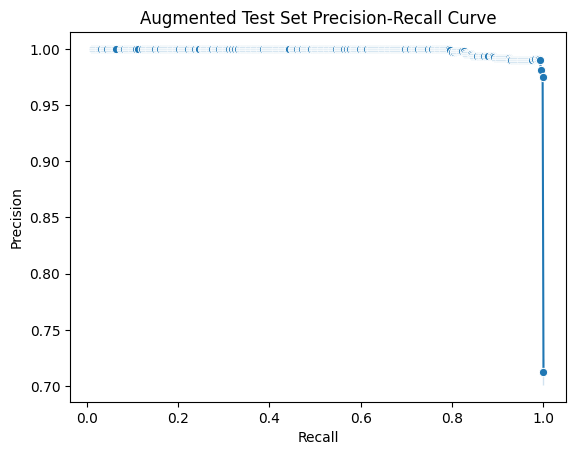

In [68]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Augmented Test Set Precision-Recall Curve')
plt.show()

### Plot a ROC Curve for our Gold Labeled Data

We need to see the ROC Curve for our gold labeled data as well. We care more about performance on this data.

In [69]:
y_true = gold_df["Label"]
y_scores = gold_df.apply(sbert_match_lower, axis=1)

In [70]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

Best Threshold: 0.9196061613581115
Best F1 Score: 0.8235294117647058
AUC-ROC: 0.7902439024390244


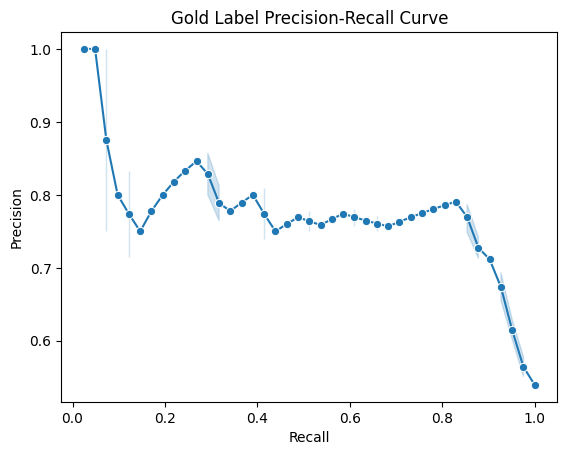

In [71]:
# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gold Label Precision-Recall Curve')
plt.show()

In [72]:
sbert_compare_lower(
    "nw 5th ave",
    "northwest 5th avenue"
)

0.9602365981440013

In [73]:
sbert_compare_lower(
    "101 market square, seattle, wa 98039",
    "101 davis ct., seattle, wa 98039"
)

0.8264309323810511

## Structured Prediction with a `Sentence-BERT` Classifier

Embeddings as a solution to this problem have a side-effect of optimizing an embedding for information retrieval... but they ignore the structure of parsed addresses. A deep network that is aware of it can perform better. Let's try out an implementation of the Sentence-BERT model, which was outlined by Nils Reimers and Iryna Gurevych in the original paper that created sentence tranformers, [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks
](https://arxiv.org/abs/1908.10084).

In [74]:
train_df, tmp_df = train_test_split(augment_results_df, test_size=0.2, shuffle=True)
eval_df, test_df = train_test_split(tmp_df, test_size=0.5, random_state=42, shuffle=True)

# Encode the addresses using [COL] / [VAL] special characters
train_dataset = Dataset.from_dict({
    "sentence1": [structured_encode_address(x) for x in train_df["Address1"].tolist()],
    "sentence2": [structured_encode_address(x) for x in train_df["Address2"].tolist()],
    "label": train_df["Label"].tolist(),
})

# Encode the addresses using [COL] / [VAL] special characters
eval_dataset = Dataset.from_dict({
    "sentence1": [structured_encode_address(x) for x in eval_df["Address1"].tolist()],
    "sentence2": [structured_encode_address(x) for x in eval_df["Address2"].tolist()],
    "label": eval_df["Label"].tolist(),
})

# Encode the addresses using [COL] / [VAL] special characters
test_dataset = Dataset.from_dict({
    "sentence1": [structured_encode_address(x) for x in test_df["Address1"].tolist()],
    "sentence2": [structured_encode_address(x) for x in test_df["Address2"].tolist()],
    "label": test_df["Label"].tolist(),
})

print(f"Training data:   {len(train_df):,}")
print(f"Validation data: {len(eval_df):,}")
print(f"Test data        {len(eval_df):,}")

Training data:   8,024
Validation data: 1,003
Test data        1,003


In [75]:
SBERT_INPUT_MODEL = SBERT_LOWER_OUTPUT_FOLDER
VARIANT = "pre-trained-embeddings"
MODEL_SAVE_NAME = ("Sentence-BERT" + "-" + VARIANT).replace("/", "-")

EPOCHS = 15
BATCH_SIZE = 32
PATIENCE = 2
LEARNING_RATE = 2e-5
MODEL_OUTPUT_FOLDER = f"data/{MODEL_SAVE_NAME}"
SAVE_EVAL_STEPS = 100

In [76]:
# # Initialize Weights & Biases
# wandb.init(
#     entity="rjurney",
#     # set the wandb project where this run will be logged
#     project="libpostal-reborn",
#     # track hyperparameters and run metadata
#     config={
#         "model": "Sentence-BERT",
#         "variant": VARIANT,
#         "epochs": EPOCHS,
#         "batch_size": BATCH_SIZE,
#         "patience": PATIENCE,
#         "learning_rate": LEARNING_RATE,
#         "sbert_input_model": SBERT_INPUT_MODEL,
#         "model_output_folder": MODEL_OUTPUT_FOLDER,
#         "save_eval_steps": SAVE_EVAL_STEPS,
#         "model_save_name": MODEL_SAVE_NAME,
#     },
#     save_code=True,
# )

In [145]:
class SentenceBERT(nn.Module):
    def __init__(self, model_name=SBERT_MODEL_LOWER, dim=384):
        super().__init__()
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.sigmoid = nn.Sigmoid()

        # # Update the input dimension of the FFNN to account for the new features
        # self.ffnn = nn.Sequential(
        #     nn.Linear(3 * dim, 1)
        # )
    
        # Update the input dimension of the FFNN to account for the new features
        self.ffnn = nn.Sequential(
            nn.Linear(3 * dim, dim),  
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(dim, 1)
        )

        # self.ffnn = nn.Sequential(
        #     nn.Linear(4 * dim + 1, dim),
        #     nn.GELU(),
        #     nn.Dropout(0.1),
        #     nn.Linear(dim, dim // 2),
        #     nn.GELU(),
        #     nn.Dropout(0.1),
        #     nn.Linear(dim // 2, 1)
        # )

    @staticmethod
    def mean_pool(token_embeds, attention_mask):
        in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
        pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
        return pool

    def _check_similarity(self, a, b, mask_a, mask_b):
        u = self.model(a, attention_mask=mask_a)[0]
        v = self.model(b, attention_mask=mask_b)[0]
        u = self.mean_pool(u, mask_a)
        v = self.mean_pool(v, mask_b)

        # Construct ( u, v, |u-v| ) same as sbert paper
        uv = torch.sub(u, v)
        uv_abs = torch.abs(uv)
        x = torch.cat([u, v, uv_abs], dim=-1)
        
        x = self.sigmoid(self.ffnn(x).float())
        return x

    def check_similarity(self, a, b):
        encoded_a = self.tokenizer(a, padding=True, truncation=True, return_tensors="pt")
        encoded_b = self.tokenizer(b, padding=True, truncation=True, return_tensors="pt")
        a = encoded_a["input_ids"].to(self.model.device)
        b = encoded_b["input_ids"].to(self.model.device)
        mask_a = encoded_a["attention_mask"].to(self.model.device)
        mask_b = encoded_b["attention_mask"].to(self.model.device)
        with torch.no_grad():
            return self._check_similarity(a, b, mask_a, mask_b)

    def forward(self, input_ids_a, input_ids_b, attention_mask_a=None, attention_mask_b=None, labels=None):
        logits = self._check_similarity(input_ids_a, input_ids_b, attention_mask_a, attention_mask_b)
        loss = None
        if labels is not None:
            loss_fct = nn.BCELoss()
            labels = labels.float().unsqueeze(1)
            probs = torch.sigmoid(logits)
            loss = loss_fct(probs, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}

    def predict(self, a: str, b: str):
        with torch.no_grad():
            probabilities = self.check_similarity(a, b)
            predicted_class = (probabilities > 0.5).long().item()
            return predicted_class, probabilities.item()

In [146]:
classifier_model = SentenceBERT()

In [147]:
tokenized_train_dataset = train_dataset.map(lambda x: tokenize_function(x, classifier_model), batched=True)
tokenized_eval_dataset = eval_dataset.map(lambda x: tokenize_function(x, classifier_model), batched=True)
tokenized_test_dataset = test_dataset.map(lambda x: tokenize_function(x, classifier_model), batched=True)

tokenized_train_dataset = format_dataset(tokenized_train_dataset)
tokenized_eval_dataset = format_dataset(tokenized_eval_dataset)
tokenized_test_dataset = format_dataset(tokenized_test_dataset)

Map:   0%|          | 0/8024 [00:00<?, ? examples/s]

Map:   0%|          | 0/1003 [00:00<?, ? examples/s]

Map:   0%|          | 0/1003 [00:00<?, ? examples/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=MODEL_OUTPUT_FOLDER,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_ratio=0.1,
    run_name=MODEL_SAVE_NAME,
    load_best_model_at_end=True,
    save_steps=SAVE_EVAL_STEPS,
    eval_steps=SAVE_EVAL_STEPS,
    save_strategy="steps",
    eval_strategy="steps",
    greater_is_better=False,
    metric_for_best_model="eval_loss",
    weight_decay=0.01,
    logging_dir="./logs",
    use_mps_device=True,
    optim="adamw_torch",
)

# Define RAdam optimizer function
def build_radam_optimizer(model, lr):
    return RAdam(model.parameters(), lr=lr)

optimizer = build_radam_optimizer(classifier_model, lr=training_args.learning_rate)


class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fct = torch.nn.BCEWithLogitsLoss()

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").float()
        input_ids_a = inputs.get("input_ids_a")
        attention_mask_a = inputs.get("attention_mask_a")
        input_ids_b = inputs.get("input_ids_b")
        attention_mask_b = inputs.get("attention_mask_b")
        outputs = model(input_ids_a, input_ids_b, attention_mask_a, attention_mask_b)
        loss = self.loss_fct(outputs['logits'].view(-1), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=classifier_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
    compute_metrics=compute_classifier_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=PATIENCE)],
    optimizers=(optimizer, None),
)

# Train the model
trainer.train()

Step,Training Loss,Validation Loss


In [ ]:
print(f"Best model checkpoint path: {trainer.state.best_model_checkpoint}")

In [ ]:
# Evaluate the model
pd.DataFrame([trainer.evaluate()])

### Save the Best Model

Because we used `load_best_model_at_end=True`, our model is now the best one we fine-tuned. Save it.

In [ ]:
trainer.save_model(MODEL_OUTPUT_FOLDER)

In [ ]:
save_custom_model(classifier_model, "data/classifier_model_for_tanmoy.pt")

In [ ]:
# wandb.finish()

### Testing the Model

In [ ]:
# classifier_model = load_custom_model(SentenceBERT, "data/classifier_model_for_tanmoy.pt", device=device)

In [ ]:
classifier_model.predict("3413 Sean Way, Lawrenceville, GA 30044", "3413 Sean Way, Lawrenceville, GA 30044")

In [ ]:
classifier_model.predict("101 Oak Ct.,", "101 Oak Street, Philadelphia, PA")

In [ ]:
classifier_model.predict("101 Oak Pl.", "101 Oak Place")

### Probability and Boolean Prediction Methods

In [ ]:
def classifier_match(row: pd.Series) -> pd.Series:
    """classifier_match - Sentence-BERT address matching, float output"""
    return classifier_model.predict(row["Address1"], row["Address2"])[1]


def classifier_match_boolean(row: pd.Series, threshold=0.5) -> pd.Series:
    """classifier_match_binary - Sentence-BERT address matching, boolean output"""
    return 1 if classifier_model.predict(row["Address1"], row["Address2"])[1] > threshold else 0

### Synthetic Data Evaluation

In [ ]:
y_true = test_df["Label"]
y_scores = test_df.apply(classifier_match, axis=1)

In [ ]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

In [ ]:
# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Augmented Test Set Precision-Recall Curve')
plt.show()

### Gold Label Evaluation

In [ ]:
y_true = gold_df["Label"]
y_scores = gold_df.apply(classifier_match, axis=1)

In [ ]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

# Compute F1 score for each threshold
f1_scores = [f1_score(y_true, y_scores >= t) for t in thresholds]

# Find the threshold that maximizes the F1 score
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]
best_f1_score = f1_scores[best_threshold_index]

print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1_score}')

roc_auc = roc_auc_score(y_true, y_scores)
print(f'AUC-ROC: {roc_auc}')

# Create a DataFrame for Seaborn
pr_data = pd.DataFrame({
    'Precision': precision[:-1],
    'Recall': recall[:-1],
    'F1 Score': f1_scores
})

In [ ]:
# Plot Precision-Recall curve using Seaborn
sns.lineplot(data=pr_data, x='Recall', y='Precision', marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gold Label Precision-Recall Curve')
plt.show()

In [ ]:
raw_df, grouped_df = gold_label_report(
    gold_df,
    [
        # sbert_match_binary,
        classifier_match_boolean,
    ],
    threshold=best_threshold
)

In [ ]:
grouped_df

In [ ]:
# Truthiness analysis
correct_df = raw_df[raw_df["classifier_match_boolean_correct"]].reset_index(drop=True)
print(f"Number correct: {len(correct_df):,}")

correct_df.head(20)

In [ ]:
# Error analysis
wrong_df = raw_df[raw_df["classifier_match_boolean_correct"] == False].reset_index()
print(f"Number wrong: {len(wrong_df):,}")

wrong_df.head(20)

In [ ]:
classifier_model.predict(
    "101 Oak Lane, Atlanta, GA 30308",
    "102 Oak Lane, Atlanta, GA 30308",
)

In [ ]:
classifier_model.predict(
    "101 Oak Lane, Macon, GA 30308",
    "101 Oak Lane, Atlanta, GA 30408",
)

In [ ]:
classifier_model.predict(
    "101 Oak Lane, Atlanta, GA 30308",
    "101 Oak Ln., Atlanta, GA 30308",
)

In [ ]:
classifier_model.predict(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "1202 Oak Rd., Lawrenceville, GA 30304",
)

In [ ]:
classifier_model.predict(
    "3413 Sean Way, Lawrenceville, GA 30044",
    "3413 Sean Way, Lawrenceville, GA 30044, USA",
)